In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import catboost as cb
import seaborn as sns
from itertools import product

%matplotlib inline

# Parse data

In [2]:
train = pd.read_csv("train.csv", delimiter="\t")
test = pd.read_csv("test.csv", delimiter="\t")
train = train[train.goal.isna() == False]
train["id"] = np.nan
test["lith"] = np.nan
test["goal"] = np.nan
matrix = pd.concat([train, test], sort=False)
matrix.rename(columns = {"well id" : "well_id", "depth, m" : "depth"}, inplace=True)
matrix.sort_values(by = ["well_id", "depth"], inplace=True)
matrix.reset_index(inplace=True)
matrix.drop("index", axis=1, inplace=True)
del train
del test
matrix.head()

,well_id,depth,bk,GZ1,GZ2,GZ3,GZ4,GZ5,GZ7,DGK,NKTD,NKTM,NKTR,ALPS,lith,goal,id
0,1.0,2184.3370,0.298388,0.116445,0.538473,0.347987,0.491279,0.141119,0.799863,0.427112,0.341992,NaN,0.464672,0.427292,ALEVROLIT,0.0,NaN
1,1.0,2184.4265,0.348636,0.125491,0.469823,0.324475,0.434475,0.145947,0.736663,0.457854,0.351583,NaN,0.452422,0.515679,ALEVROLIT,0.0,NaN
2,1.0,2184.5160,0.398885,0.133636,0.435799,0.396194,0.377676,0.158827,0.682340,0.374453,0.361175,NaN,0.442414,0.575843,ALEVROLIT,0.0,NaN
3,1.0,2184.6055,0.388287,0.151152,0.454628,0.292968,0.375368,0.148768,0.647392,0.416252,0.377926,NaN,0.416366,0.547347,ALEVROLIT,0.0,NaN
4,1.0,2184.6950,0.377173,0.168667,0.473443,0.284973,0.373649,0.146652,0.612278,0.447254,0.394666,NaN,0.392498,0.433617,ALEVROLIT,0.0,NaN


# Value metric

In [3]:
def value_metric(df, y_true, y_pred, exp_types=[], costs_filename="costs.csv", eps= 1e-2, normalize=True):
    TP = sum([1 if (a == 1) and (b == 1) else 0 for a, b in zip(list(y_true), list(y_pred))])
    FP = sum([1 if (a == 0) and (b == 1) else 0 for a, b in zip(list(y_true), list(y_pred))])
    costs = pd.read_csv("costs.csv")
    oil_cost, perf_cost = int(costs[costs.name == "oil"].value) , int(costs[costs.name == "perf"].value)
    result = oil_cost * TP - perf_cost * (TP + FP)
    for exp_type in exp_types:
        if (exp_type in costs.name.values):
            result -= df.shape[0] * int(costs[costs.name == exp_type].value)
        else:
            print("Exploration type ", exp_type, "is unknown")
        
    if normalize:
        denom = sum(y_true)*(oil_cost - perf_cost)
    else:
        denom = df.well_id.nunique()
    
    result /= denom + eps
    #print("TP:", TP, "FP:", FP, "oil cost:", oil_cost, "perf_cost:", perf_cost)
    return result

# Preprocessing

In [4]:
def moving_average(series, window_size=5):
    return series.rolling(window=window_size).mean()

## Init selection and filling NaNs

In [5]:
init_columns = list(set(matrix.columns.values) - set(["goal", "lith", "id"]))

In [6]:
for column in init_columns:
    matrix[column].fillna(matrix[column].median(), inplace=True)
matrix[init_columns].head()

,NKTR,GZ5,GZ7,depth,NKTD,GZ1,ALPS,DGK,GZ2,bk,NKTM,GZ4,well_id,GZ3
0,0.464672,0.141119,0.799863,2184.3370,0.341992,0.116445,0.427292,0.427112,0.538473,0.298388,0.521879,0.491279,1.0,0.347987
1,0.452422,0.145947,0.736663,2184.4265,0.351583,0.125491,0.515679,0.457854,0.469823,0.348636,0.521879,0.434475,1.0,0.324475
2,0.442414,0.158827,0.682340,2184.5160,0.361175,0.133636,0.575843,0.374453,0.435799,0.398885,0.521879,0.377676,1.0,0.396194
3,0.416366,0.148768,0.647392,2184.6055,0.377926,0.151152,0.547347,0.416252,0.454628,0.388287,0.521879,0.375368,1.0,0.292968
4,0.392498,0.146652,0.612278,2184.6950,0.394666,0.168667,0.433617,0.447254,0.473443,0.377173,0.521879,0.373649,1.0,0.284973


# Feature engineering

## Generation

### Depth features

In [7]:
depth_stats = matrix.groupby("well_id").aggregate({"depth" : ["mean", "std"]})
depth_stats.columns = ['_'.join(col).strip() for col in depth_stats.columns.values]
depth_stats.reset_index(inplace=True)
matrix = pd.merge(matrix, depth_stats, on="well_id", how="left")
matrix["norm_depth"] = (matrix.depth - matrix.depth_mean)/(matrix.depth_std + 1e-1)

### Interactions

In [8]:
matrix["GZ1_ALPS_mul"] = matrix.GZ1 * matrix.ALPS

### Neighbors

In [10]:
def feature_lags(df, column, period=1):
    well_ids = matrix.well_id.unique()
    matrix[column + "_prev_" + str(period)] = np.nan
    matrix[column + "_next_" + str(period)] = np.nan
    for well_id in well_ids:
        cond = matrix.well_id == well_id
        _prev = matrix[cond][column] - matrix[cond][column].diff(periods=period)
        _next = matrix[cond][column] - matrix[cond][column].diff(periods=-period)
        matrix.loc[cond, column + "_prev_" + str(period)] = _prev 
        matrix.loc[cond, column + "_next_" + str(period)] = _next
        
    matrix[column + "_prev_" + str(period)].fillna(matrix[column].median(), inplace=True)
    matrix[column + "_next_" + str(period)].fillna(matrix[column].median(), inplace=True)

In [11]:
for column, period in product(["ALPS", "GZ1"], list(range(1, 6))):
    feature_lags(matrix, column, period)

## Final selection

In [12]:
final_columns = ["well_id", "ALPS", "GZ1",
                 "depth", "norm_depth",
                 "GZ1_ALPS_mul",
                "ALPS_prev_1", "ALPS_prev_2", "ALPS_next_1", "ALPS_next_2",   
                 "GZ1_prev_2", "GZ1_next_2", "GZ1_next_3", "GZ1_next_4", "GZ1_next_5"]
matrix[final_columns].head()

,well_id,ALPS,GZ1,depth,norm_depth,GZ1_ALPS_mul,ALPS_prev_1,ALPS_prev_2,ALPS_next_1,ALPS_next_2,GZ1_prev_2,GZ1_next_2,GZ1_next_3,GZ1_next_4,GZ1_next_5
0,1.0,0.427292,0.116445,2184.3370,-1.717372,0.049756,0.336690,0.336690,0.515679,0.575843,0.242622,0.133636,0.151152,0.168667,0.176939
1,1.0,0.515679,0.125491,2184.4265,-1.712322,0.064713,0.427292,0.336690,0.575843,0.547347,0.242622,0.151152,0.168667,0.176939,0.185298
2,1.0,0.575843,0.133636,2184.5160,-1.707271,0.076954,0.515679,0.427292,0.547347,0.433617,0.116445,0.168667,0.176939,0.185298,0.186183
3,1.0,0.547347,0.151152,2184.6055,-1.702221,0.082733,0.575843,0.515679,0.433617,0.449431,0.125491,0.176939,0.185298,0.186183,0.187156
4,1.0,0.433617,0.168667,2184.6950,-1.697171,0.073137,0.547347,0.575843,0.449431,0.465243,0.133636,0.185298,0.186183,0.187156,0.186267


# Validation

In [56]:
def validate_model(model, X, y, n_splits=5, exp_types=[], threshold=None):
    # fix cv strategy
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    well_ids = X.well_id.unique()
    f_scores, value_scores = [], []
    
    # validate 
    for train_ids, val_ids in cv.split(well_ids):
        train_index = X[X.well_id.isin(train_ids)].index
        val_index = X[X.well_id.isin(val_ids)].index
        model.fit(X.loc[train_index, :].drop("well_id", axis=1), y[train_index])
        
        if threshold is None:
            y_pred = model.predict(X.loc[val_index, :].drop("well_id", axis=1))
        else:
            y_pred_proba = pd.Series(data=model.predict_proba(X.loc[val_index, :].drop("well_id", axis=1))[:, 1],
                      index=val_index)
            y_pred_proba = moving_average(y_pred_proba)
            y_pred = np.where(y_pred_proba > threshold, 1, 0)
                
        precision = precision_score(y[val_index], y_pred)
        recall = recall_score(y[val_index], y_pred)
        accuracy = accuracy_score(y[val_index], y_pred)
        f_score = f1_score(y[val_index], y_pred)
        value_score = value_metric(X.loc[val_index, :], y[val_index], y_pred, exp_types=exp_types)
        f_scores.append(f_score)
        value_scores.append(value_score)
        print("F1 score: ", f_score, "; value: ", value_score)
        print("Precision: ", precision, "; recall: ", recall, "accuracy: ", accuracy)
        
    return f_scores, value_scores

## Train/control/test split

In [57]:
# Train and control
matrix_tc = matrix.loc[matrix.goal.isna() == False, :]
well_ids_train, well_ids_control = train_test_split(matrix_tc.well_id.unique(), test_size=5, shuffle=True, random_state=42)
X_train = matrix_tc[matrix_tc.well_id.isin(well_ids_train)][final_columns]
y_train = matrix_tc[matrix_tc.well_id.isin(well_ids_train)].goal
X_control = matrix_tc[matrix_tc.well_id.isin(well_ids_control)][final_columns]
y_control = matrix_tc[matrix_tc.well_id.isin(well_ids_control)].goal

# Test
X_test = matrix[matrix.goal.isna()][final_columns]
ids_test = matrix[matrix.goal.isna()].id
del matrix_tc

## XGBoost fitting

In [21]:
xgb_classifier = xgb.XGBClassifier(n_estimators=30,
                                   max_depth=6,
                                   objective="binary:logistic",
                                   n_thread=4,
                                   random_state=0)
f_scores, value_scores = validate_model(xgb_classifier, X_train, y_train, exp_types=["GZ", "ALPS"], threshold=0.2)
np.array(f_scores).mean(), np.array(value_scores).mean()

F1 score:  0.5750394944707741 ; value:  0.47293134964374506
Precision:  0.5144377320844649 ; recall:  0.6518258426966292 accuracy:  0.8522741956325106
F1 score:  0.6300575830377912 ; value:  0.5967583628078696
Precision:  0.5141594572726707 ; recall:  0.813410791650256 accuracy:  0.8755867340395517
F1 score:  0.6024038461538462 ; value:  0.5054433615767431
Precision:  0.5404855804781858 ; recall:  0.6803443996276761 accuracy:  0.863772208495117
F1 score:  0.6484960440556272 ; value:  0.5865086768184503
Precision:  0.5635108122842086 ; recall:  0.7636677064521425 accuracy:  0.875034075983247
F1 score:  0.6052711993888464 ; value:  0.5754944303721298
Precision:  0.48281535648994517 ; recall:  0.8109518935516888 accuracy:  0.8682996457064206


(0.6122536334213771, 0.5474272362437876)

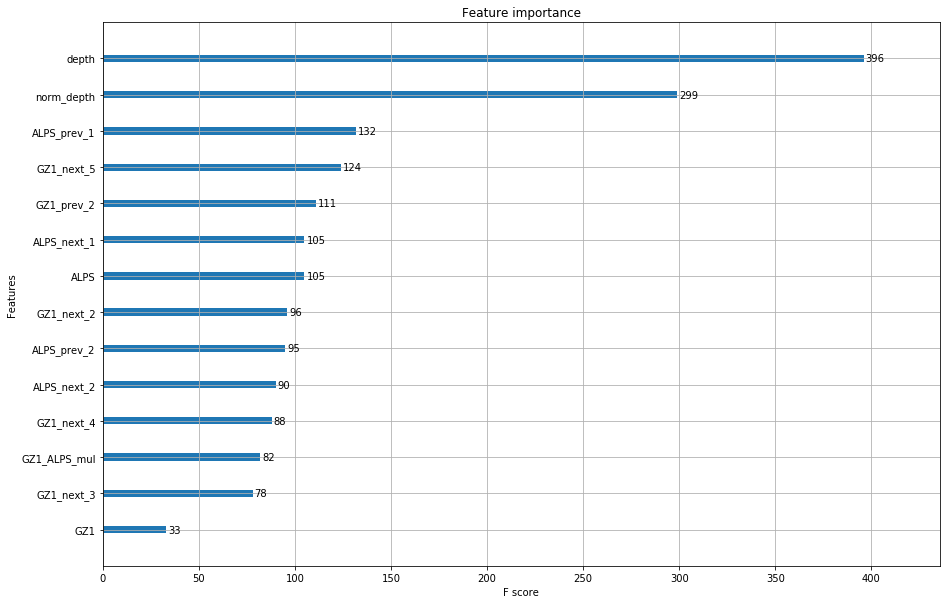

In [22]:
plt.figure(figsize=(15, 10))
ax = plt.subplot()
xgb.plot_importance(xgb_classifier, ax=ax)

## CatBoost fitting

In [65]:
cb_classifier = cb.CatBoostClassifier(n_estimators=30,
                                      max_depth=6,
                                      objective="Logloss",
                                      silent=True,
                                      random_state=0)

f_scores, value_scores = validate_model(cb_classifier, X_train, y_train, exp_types=["GZ", "ALPS"], threshold=0.2)
np.array(f_scores).mean(), np.array(value_scores).mean()

F1 score:  0.5875108245934765 ; value:  0.473695126121663
Precision:  0.5407048822244525 ; recall:  0.643188202247191 accuracy:  0.8615131153895852
F1 score:  0.6447974583002383 ; value:  0.5947715747788186
Precision:  0.5403354632587859 ; recall:  0.7993304450571092 accuracy:  0.8852950983661221
F1 score:  0.5870838925076103 ; value:  0.507661570019657
Precision:  0.5078430262189252 ; recall:  0.6956251939187093 accuracy:  0.8515707730321215
F1 score:  0.6377142042823043 ; value:  0.560544975058056
Precision:  0.5633536854031598 ; recall:  0.7346905270070596 accuracy:  0.8739932095858839
F1 score:  0.6103645255414457 ; value:  0.5434814591519296
Precision:  0.5099224060976447 ; recall:  0.7600818833162744 accuracy:  0.8791705961817857


(0.613494181045015, 0.5360309410260248)

<BarContainer object of 14 artists>

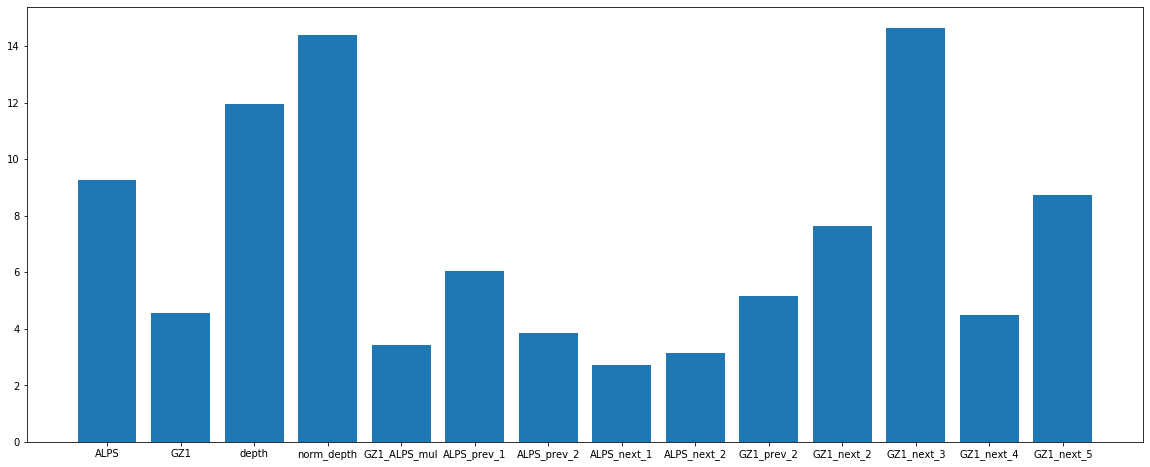

In [66]:
importances = cb_classifier.feature_importances_
names = X_train.drop("well_id", axis=1).columns.values

plt.figure(figsize=(20, 8))
plt.bar(names, importances)

# Params tuning

In [76]:
total_f, total_value = [], []
for thr in [x/20 for x in range(0, 10)]:
    print("Thr: ", thr)
    f_scores, value_scores = validate_model(cb_classifier, X_train, y_train, exp_types=["GZ", "ALPS"], threshold=thr)
    total_f.append(np.array(f_scores).mean())
    total_value.append(np.array(value_scores).mean())

Thr:  0.0
F1 score:  0.2658350761876307 ; value:  0.15125396948231531
Precision:  0.15329944865609924 ; recall:  0.9997191011235955 accuracy:  0.15329284575957272
F1 score:  0.23048816467330865 ; value:  -0.02299716471343466
Precision:  0.13025522636911632 ; recall:  1.0 accuracy:  0.13029984353758944
F1 score:  0.2634299842661272 ; value:  0.1408798683964278
Precision:  0.1516955733885581 ; recall:  1.0 accuracy:  0.15173549829391694
F1 score:  0.2623169681309216 ; value:  0.13601451391914085
Precision:  0.15095789238890678 ; recall:  1.0 accuracy:  0.15099997521746672
F1 score:  0.2214616012331127 ; value:  -0.07641156227605059
Precision:  0.12451887537916444 ; recall:  1.0 accuracy:  0.1245635052124487
Thr:  0.05
F1 score:  0.46822340910031884 ; value:  0.4811461403627667
Precision:  0.3319732284389127 ; recall:  0.7941713483146068 accuracy:  0.7233923418184951
F1 score:  0.48875974919712495 ; value:  0.5704187758995687
Precision:  0.3297338193823509 ; recall:  0.9440724694761717 ac

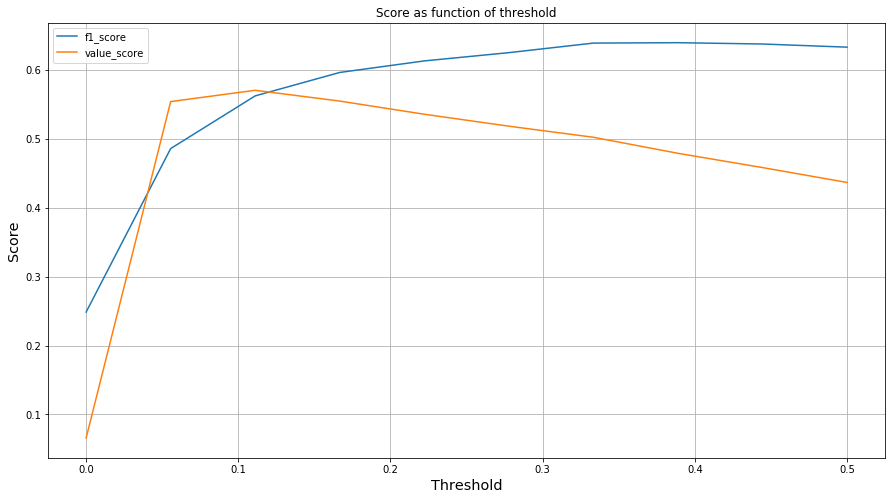

In [77]:
plt.figure(figsize=(15, 8))
plt.plot(np.linspace(0, 0.5, 10), total_f, "-", label="f1_score")
plt.plot(np.linspace(0, 0.5, 10), total_value, "-", label="value_score")
plt.title("Score as function of threshold")
plt.xlabel("Threshold", size="x-large")
plt.ylabel("Score", size="x-large")
plt.legend()
plt.grid()

plt.show()

# Fit and predict

In [72]:
def fit_and_predict(model, X_train, y_train, X_test, y_test=None, exp_types=[], threshold=0.5):
    
    # fit model on train and predict on test
    model.fit(X_train.drop("well_id", axis=1), y_train)
    y_pred_proba = moving_average(pd.Series(data=model.predict_proba(X_test.drop("well_id", axis=1))[:, 1],
                      index=X_test.drop("well_id", axis=1).index))
    y_pred = np.where(y_pred_proba > threshold, 1, 0)
    
    # Calc metrics
    if not(y_test is None):
        f_score = f1_score(y_test, y_pred)
        value_score = value_metric(X_test, y_test, y_pred, exp_types=exp_types)
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        print("f_score: ", f_score)
        print("Value_score: ", value_score)
        print("Accuracy score: ", accuracy)
        print("Precision score: ", precision)
        print("Recall score: ", recall)
    
    # Plot result
    plt.figure(figsize=(15, 6))
    fig, axes = plt.subplots(X_test.well_id.nunique(), 1, figsize = (15, 10 * X_test.well_id.nunique()))
    i = 0
    for well_id in X_test.well_id.unique():
        
        # test visualization
        if not(y_test is None):
            y_true_viz = y_test[X_test.well_id == well_id]
            axes[i].scatter(X_test.loc[X_test.well_id == well_id, "depth"], y_true_viz, c="green")
        
        # proba visualization
        y_pred_viz = y_pred_proba[X_test.well_id == well_id]
        axes[i].set_xlabel("Depth, m", size="x-large")
        axes[i].set_ylabel("Probability", size="x-large")
        axes[i].set_title("Probability as function of depth for well_id = " + str(well_id))
        axes[i].plot(X_test.loc[X_test.well_id == well_id, "depth"], y_pred_viz)
        axes[i].plot(X_test.loc[X_test.well_id == well_id, "depth"], threshold * np.ones(len(y_pred_viz)), c="red")
        axes[i].grid()
        i += 1
        
    return y_pred

f_score:  0.7046666666666667
Value_score:  0.6400987174271365
Accuracy score:  0.8764467996095384
Precision score:  0.6464831804281346
Recall score:  0.7743589743589744


<Figure size 1080x432 with 0 Axes>

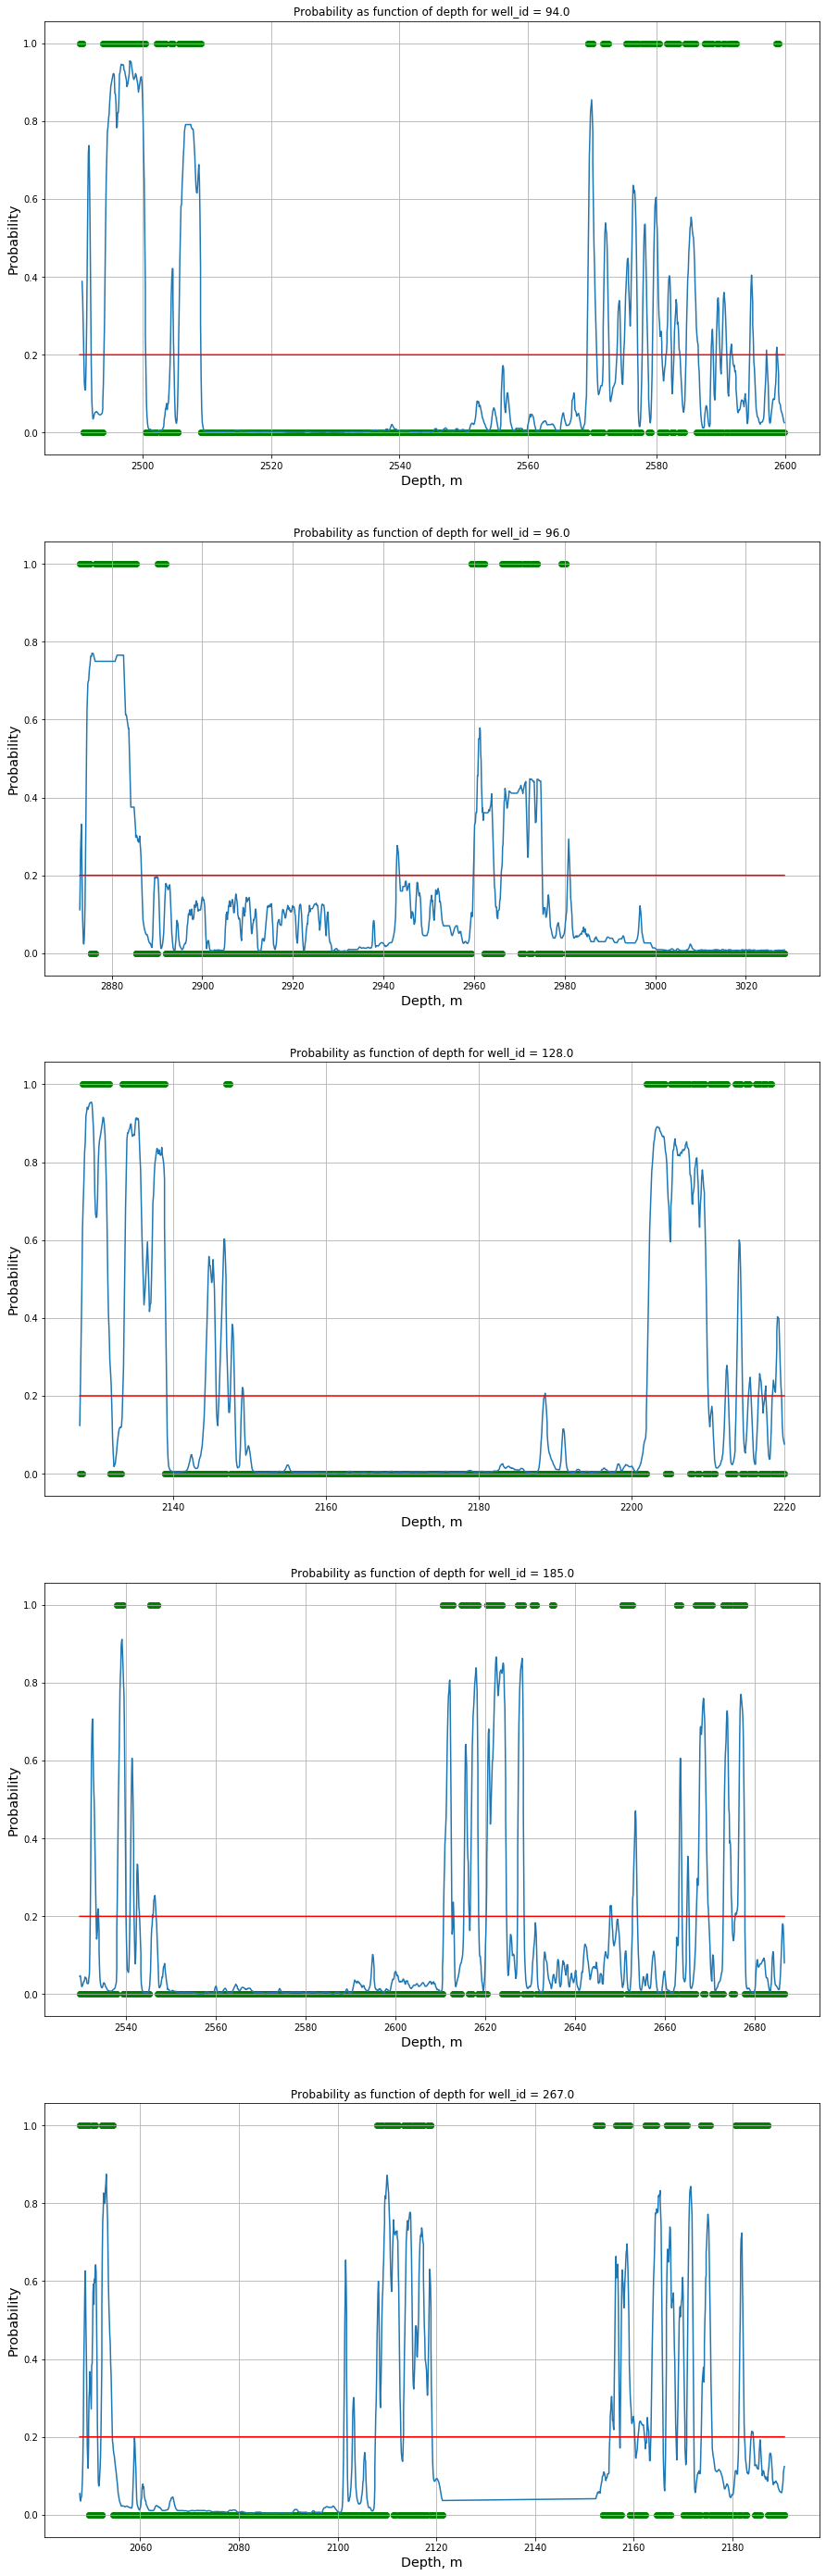

In [73]:
final_model = cb_classifier
y_pred_control = fit_and_predict(final_model, X_train, y_train, X_control, y_test=y_control, 
                                 exp_types=["GZ", "ALPS"], threshold=0.2)

<Figure size 1080x432 with 0 Axes>

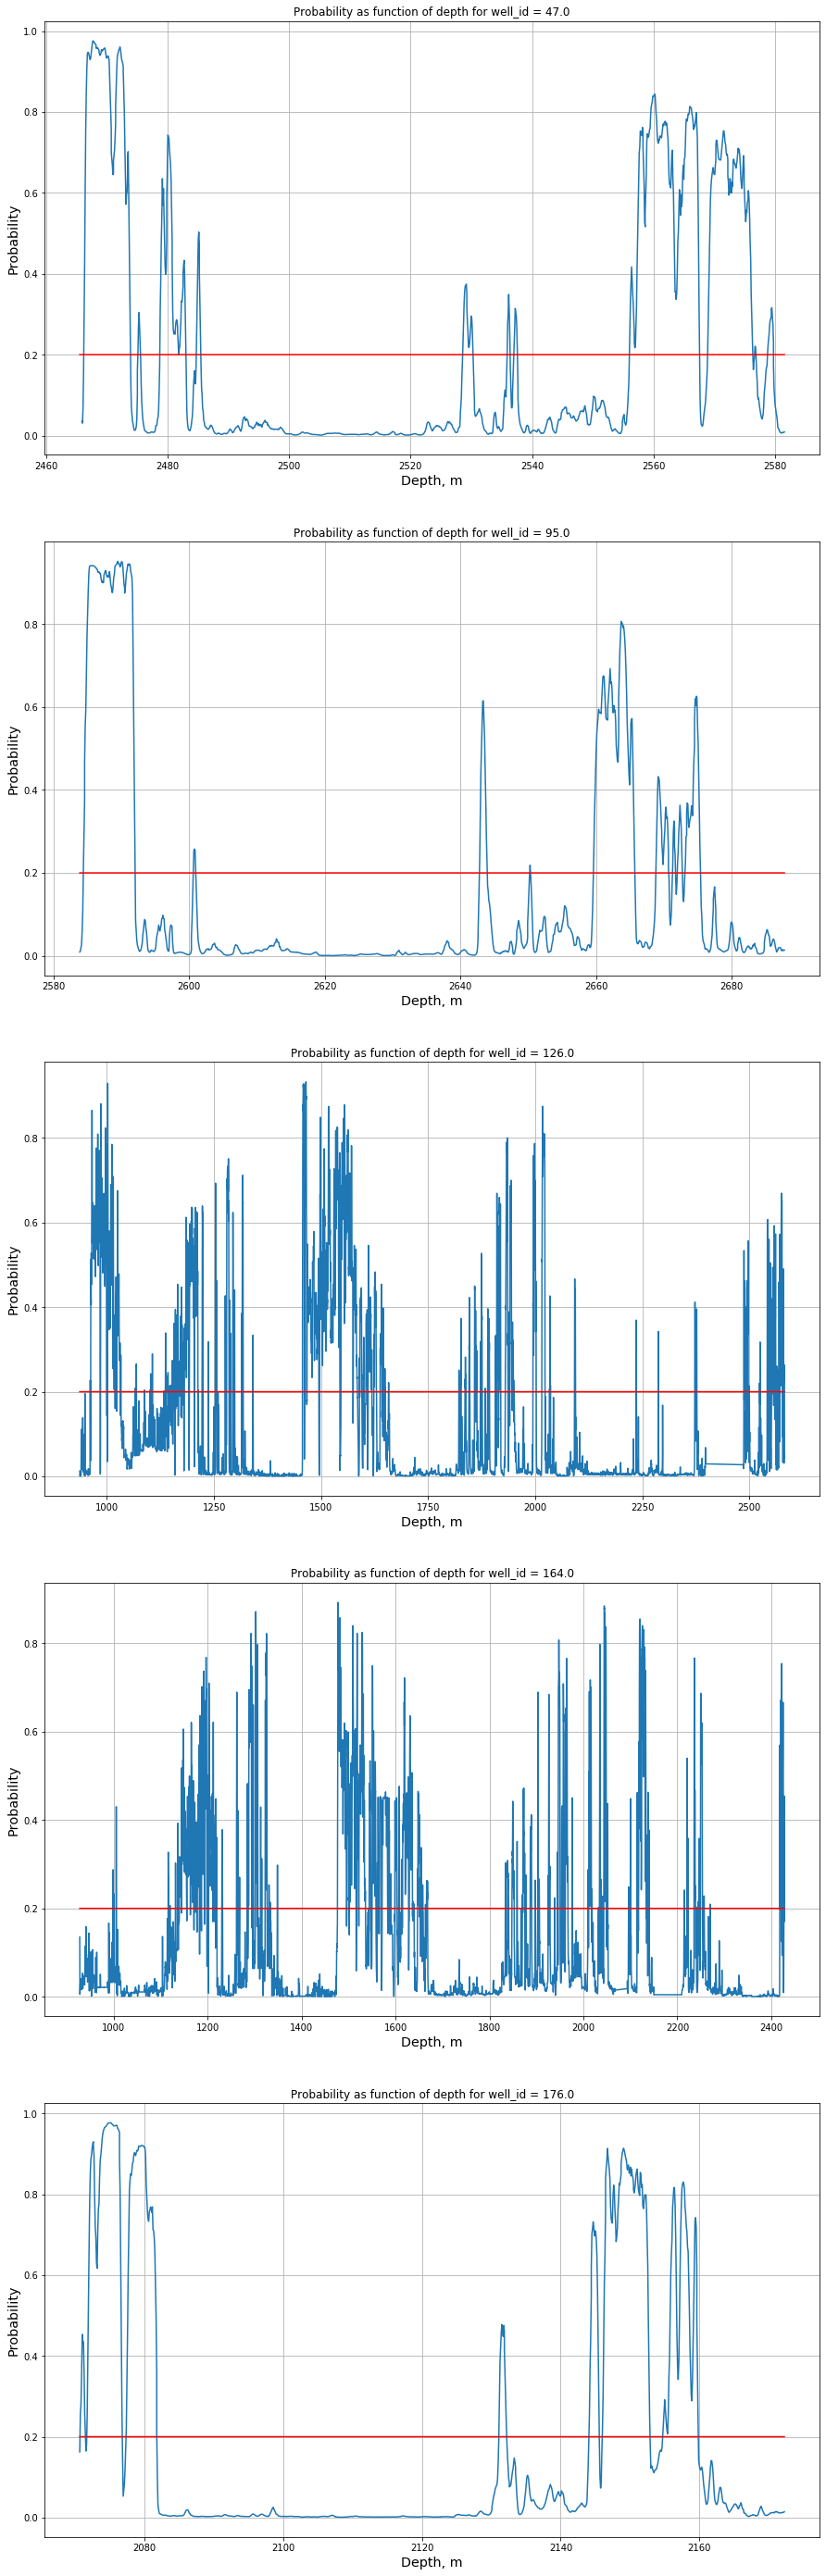

In [74]:
y_pred_test = fit_and_predict(final_model, X_train, y_train, X_test, exp_types=["GZ", "ALPS"], threshold=0.2)

# Submission

In [81]:
submission = pd.DataFrame({"id" : ids_test.astype(int), "lith" : np.nan, "goal" : y_pred_test})
submission.to_csv("result.csv")
submission.head()

,id,lith,goal
73314,1,NaN,0
73315,2,NaN,0
73316,3,NaN,0
73317,4,NaN,0
73318,5,NaN,0


In [83]:
y_pred_test.sum()/len(y_pred_test)

0.24460163812360386

# Final results

Best model:

    1) final_columns = ["well_id", "ALPS", "GZ1",
                 "depth", "norm_depth",
                "ALPS_prev_1", "ALPS_next_1", "ALPS_prev_2", "ALPS_next_2", 
                 "GZ1_prev_1", "GZ1_next_1", "GZ1_prev_2", "GZ1_next_2"]
    2) model: CatBoost, 30 trees, depth = 6
    3) f_score = 0.70, value_score = 0.64

In [21]:
value_metric(X_train, y_train, y_train, exp_types=["GZ", "ALPS"])

0.903351784617678